In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import cv2
from torchvision.transforms import InterpolationMode
import torchvision.transforms.functional as F
import skimage.metrics as metrics
import numpy as np

In [12]:
after = cv2.imread("All Euler_after.png")
before = cv2.imread("All Euler_before.png")
# First Croped Image
x = 650 
y = 500  
width = 300  
height = 300
before_image= before[y:y+height, x:x+width]

# Second Croped Image
x = 750
y = 500  
width = 300  
height = 300  

after_image = after[y:y+height, x:x+width]


img1 = cv2.cvtColor(before_image, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(after_image, cv2.COLOR_BGR2RGB)

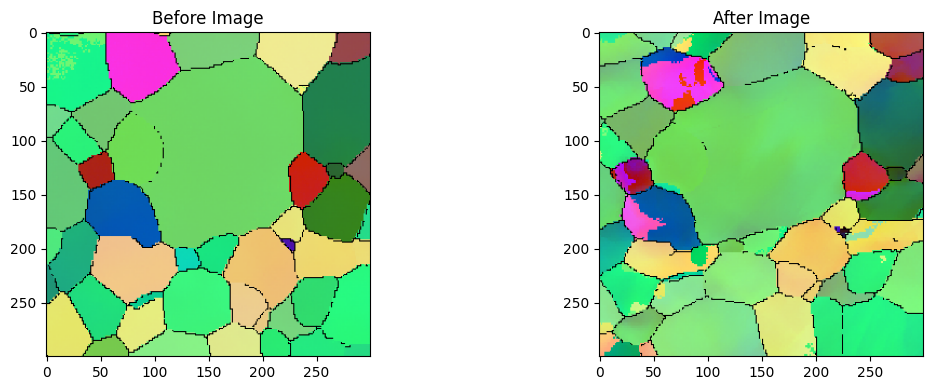

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].imshow(img1)
axs[0].set_title("Before Image")

axs[1].imshow(img2)
axs[1].set_title("After Image")

plt.tight_layout()
plt.show()

In [14]:
def draw_grid(img, grid_shape, color=(0, 0, 0), thickness=1):
    h, w, _ = img.shape
    rows, cols = grid_shape
    dy, dx = h / rows, w / cols

    # draw vertical lines
    for x in np.linspace(start=dx, stop=w-dx, num=cols-1):
        x = int(round(x))
        cv2.line(img, (x, 0), (x, h), color=color, thickness=thickness)

    # draw horizontal lines
    for y in np.linspace(start=dy, stop=h-dy, num=rows-1):
        y = int(round(y))
        cv2.line(img, (0, y), (w, y), color=color, thickness=thickness)

    return img

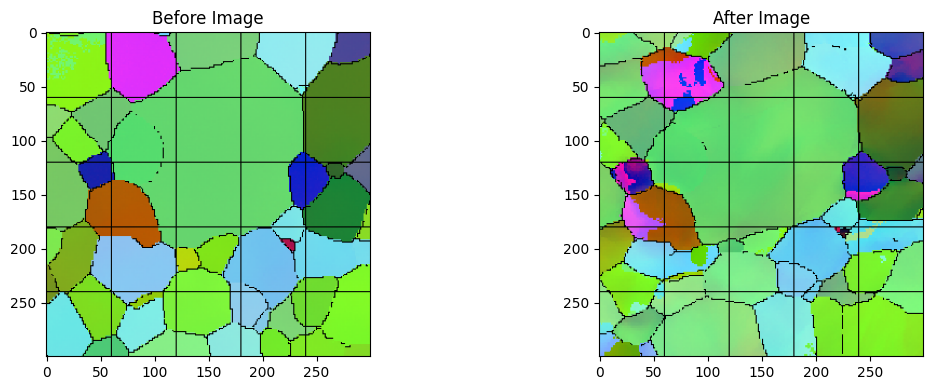

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].imshow(draw_grid(before_image, (5,5)))
axs[0].set_title("Before Image")

axs[1].imshow(draw_grid(after_image, (5,5)))
axs[1].set_title("After Image")

plt.tight_layout()
plt.show()

0
Gradients are being calculated for image1.
Epoch 1/5, Loss: 0.07087051123380661


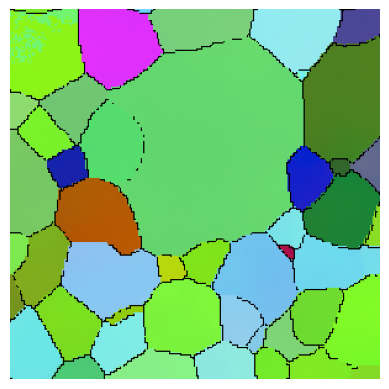

0
Gradients are not being calculated for image1.
Epoch 2/5, Loss: 0.21943137049674988


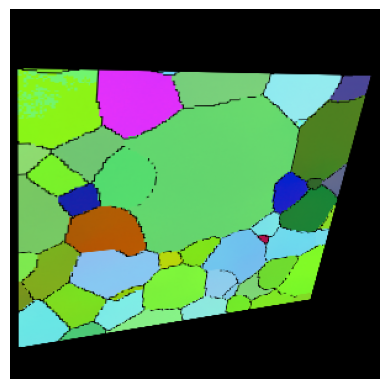

0
Gradients are not being calculated for image1.
Epoch 3/5, Loss: 0.23139634728431702


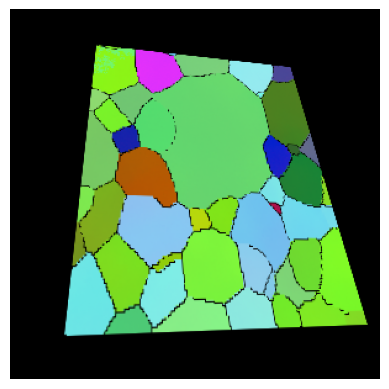

0
Gradients are being calculated for image1.
Epoch 4/5, Loss: 0.07087051123380661


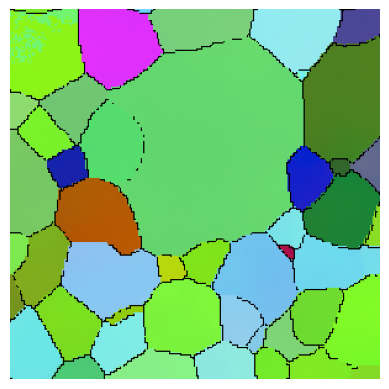

0
Gradients are being calculated for image1.
Epoch 5/5, Loss: 0.07087051123380661


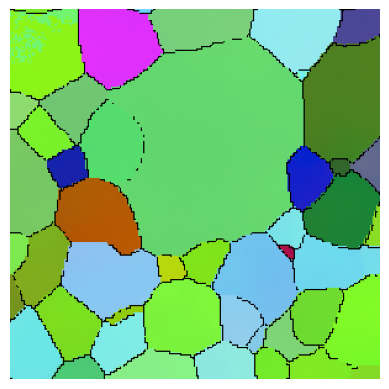

In [21]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

image1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

image1 = transform(image1)  
image2 = transform(image2)

class RandomPerspective(nn.Module):
    def __init__(self, distortion_scale=0.5, p=0.5, interpolation=InterpolationMode.BILINEAR, fill=0):
        super(RandomPerspective, self).__init__()
        self.p = p
        self.interpolation = interpolation
        self.distortion_scale = distortion_scale
        self.fill = fill
        #startpoints constant
        self.startpoints = nn.Parameter(torch.zeros(4, 2).uniform_(0, 300).round().float(), requires_grad=True)
        self.endpoints = nn.Parameter(torch.zeros(4, 2).uniform_(0, 300).round().float(), requires_grad=True)

    def forward(self, img):
        fill = self.fill
        height, width = F.get_image_size(img)
        channels = F.get_image_num_channels(img)
        
        if isinstance(img, torch.Tensor):
            if isinstance(fill, (int, float)):
                fill = [float(fill)] * channels
            else:
                fill = [float(f) for f in fill]

        if torch.rand(1) < self.p:
            startpoints, endpoints = self.get_params(width, height)
            startpoints = torch.tensor(startpoints, dtype=torch.float32)
            endpoints = torch.tensor(endpoints, dtype=torch.float32)

            self.startpoints.data = startpoints
            self.endpoints.data = endpoints
            
            transformed_img = F.perspective(img, self.startpoints.data, self.endpoints.data, self.interpolation, fill)
            return transformed_img
        
        return img
    @staticmethod
    def get_params(width, height, distortion_scale=0.5):
        half_height = height // 2
        half_width = width // 2
        topleft = [
            int(torch.randint(0, int(distortion_scale * half_width) + 1, size=(1,)).item()),
            int(torch.randint(0, int(distortion_scale * half_height) + 1, size=(1,)).item()),
        ]
        topright = [
            int(torch.randint(width - int(distortion_scale * half_width) - 1, width, size=(1,)).item()),
            int(torch.randint(0, int(distortion_scale * half_height) + 1, size=(1,)).item()),
        ]
        botright = [
            int(torch.randint(width - int(distortion_scale * half_width) - 1, width, size=(1,)).item()),
            int(torch.randint(height - int(distortion_scale * half_height) - 1, height, size=(1,)).item()),
        ]
        botleft = [
            int(torch.randint(0, int(distortion_scale * half_width) + 1, size=(1,)).item()),
            int(torch.randint(height - int(distortion_scale * half_height) - 1, height, size=(1,)).item()),
        ]
        startpoints = [[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]]
        endpoints = [topleft, topright, botright, botleft]
        return startpoints, endpoints


criterion = nn.MSELoss()

class TransformationDataset(Dataset):
    def __init__(self, image1, image2):
        self.image1 = image1
        self.image2 = image2

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return self.image1, self.image2


dataset = TransformationDataset(image1, image2)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)


model = RandomPerspective(distortion_scale=0.1, p=0.2)
optimizer = optim.SGD(model.parameters(), lr=0.01)

num_epochs = 5
for epoch in range(num_epochs):
    for batch_idx, (image1, image2) in enumerate(dataloader):
        print(batch_idx)
        optimizer.zero_grad()
        output = model(image1)
        output.requires_grad_(True)  # Enable requires_grad for the output tensor

        loss = criterion(output, image2)
        loss.backward(retain_graph=True)
        # Check if gradients are calculated for image1
        if image1.grad is not None:
            print("Gradients are being calculated for image1.")
        else:
            print("Gradients are not being calculated for image1.")
        optimizer.step()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")
    
    plt.imshow(output.squeeze().permute(1,2,0).detach().numpy())

    plt.axis('off')
    plt.show()
    
   
transformed_image1 = model(image1)

# Getting Matching Points Between the Before and After Images

True

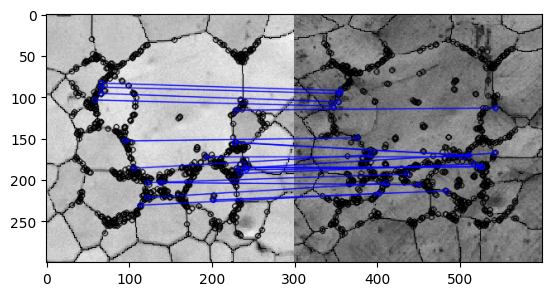

In [23]:
#Euler Images
euler_img1 = cv2.imread("All Euler_before.png")
euler_img2 = cv2.imread("All Euler_after.png")

img = cv2.imread("BAND_CONTR_before.png")
img1= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

image = cv2.imread("BAND_CONTR_after.png")
image1 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# First Croped Image
x = 650 
y = 500  
width = 300  
height = 300
cropped_img = img1[y:y+height, x:x+width]

# Second Croped Image

x = 750
y = 500  
width = 300  
height = 300  

image = cv2.imread("BAND_CONTR_after.png")
cropped_img1 = image1[y:y+height, x:x+width]

orb = cv2.ORB_create(1000)
kp1, dst1 = orb.detectAndCompute(cropped_img, None)
kp2, dst2 = orb.detectAndCompute(cropped_img1, None)

matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE_HAMMING)
matches = matcher.match(dst1, dst2, None)

# Treating matches


points1 = np.array([kp1[m.queryIdx].pt for m in matches], dtype=np.float32)
points2 = np.array([kp2[m.trainIdx].pt for m in matches], dtype=np.float32)

angle_threshold = 20  

filtered_matches = []
for match in matches:
    idx1 = match.queryIdx  # Index of the keypoint in Image 1
    idx2 = match.trainIdx  # Index of the keypoint in Image 2

    x = kp1[idx1].pt[0]
    z = kp2[idx2].pt[0]
    y = kp1[idx1].pt[1]
    w = kp2[idx2].pt[1]

    if abs(y-w) < angle_threshold and abs(x-z) < 20 and abs(x-z) > 10:
        filtered_matches.append(match)

match_image = cv2.drawMatches(
    cropped_img, kp1, cropped_img1, kp2, filtered_matches, None,
    
    matchColor=(0, 0, 255),  
    singlePointColor=(0, 0, 0)  
)

plt.imshow(match_image)
cv2.imwrite("matches.png", match_image)

In [28]:
point1 = np.zeros((len(filtered_matches), 2), dtype=np.float32)
point2 = np.zeros((len(filtered_matches), 2), dtype=np.float32)

for i, match in enumerate(filtered_matches):
    point1[i, :] = kp1[match.queryIdx].pt
    point2[i, :] = kp2[match.trainIdx].pt
    
h, _ = cv2.findHomography(point1, point2)
try:
    height, width  = cropped_img1.shape
except:
    height, width, _  = cropped_img1.shape

img1Reg = cv2.warpPerspective(cropped_img, h, (width, height))

Text(0.5, 1.0, 'Image 3')

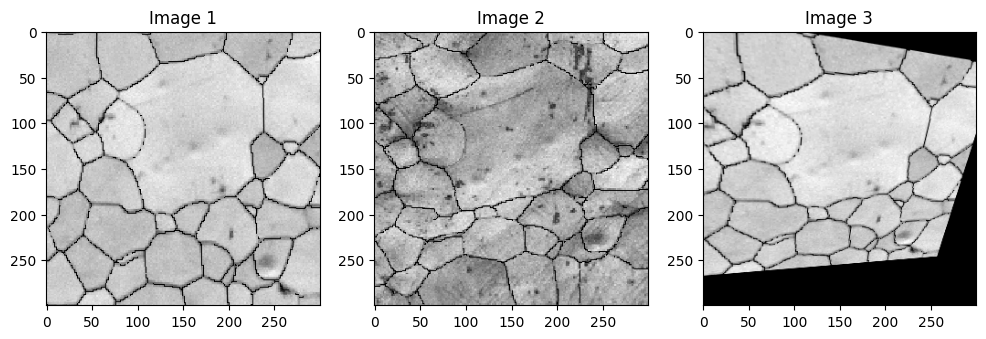

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(cropped_img, cmap='gray')
axs[0].set_title("Image 1")

axs[1].imshow(cropped_img1, cmap='gray')
axs[1].set_title("Image 2")


axs[2].imshow(img1Reg, cmap='gray')
axs[2].set_title("Image 3")